# Set up keras with tensorflow-gpu backend

In [1]:
import keras
import pandas as pd
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
data = pd.read_csv(r'C:\Users\Ido\Desktop\datasets\noshowdata.csv')


Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17171410466995797043
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1503651430
locality {
  bus_id: 1
}
incarnation: 15625928786010795034
physical_device_desc: "device: 0, name: GeForce 940M, pci bus id: 0000:06:00.0, compute capability: 5.0"
]


# Feature Engineering

In [133]:
#First, let's look at the data. Most features are binary coded.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [134]:
data[:5]
#Age, Gender, ScheduledDay and AppointmentDay, Neighbourhood all need some work to extract valuable information

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [135]:
#Let's make the No-show and Gender factors binary
data['no_show'] = data.apply(lambda x:int(x['No-show']=='Yes'),axis=1)
data['is_male'] = data.apply(lambda x:int(x['Gender']=='M'),axis=1)

#And drop the original columns
data = data.drop(columns=['Gender'],axis=0)
data = data.drop(columns=['No-show'],axis=0)

## Age 

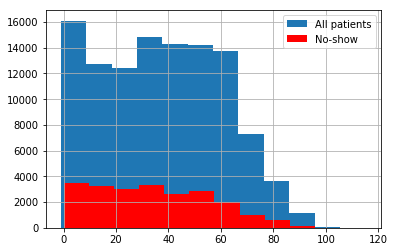

<Figure size 432x288 with 0 Axes>

In [136]:
import matplotlib.pyplot as plt
#Let's look at how the ages are distributed
ax = pd.Series(data['Age']).hist(bins=12)
ax2 = pd.Series(data[['Age','no_show']][data['no_show']==1]['Age']).hist(bins=12,color='red')
ax.legend(['All patients','No-show'])
plt.figure()
plt.show()

#Most patients are younger than 60, other than that the data is balanced in terms of age.

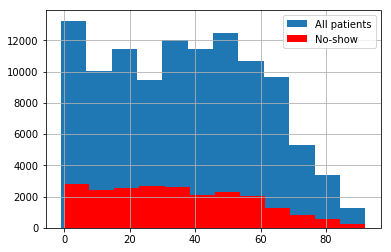

<Figure size 432x288 with 0 Axes>

,PatientId,AppointmentID,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,no_show,is_male
0,2.987250e+13,5642903,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,0,0
1,5.589978e+14,5642503,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,0,1
2,4.262962e+12,5642549,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,0,0
3,8.679512e+11,5642828,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,0
4,8.841186e+12,5642494,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,0,0


In [137]:
#I'll remove the top 0.1% to make things easier for now - but this does require some thought (accurately predict death for some very old people?)

data = data[data['Age']<data['Age'].quantile(0.999)]
ax = pd.Series(data['Age']).hist(bins=12)
pd.Series(data[['Age','no_show']][data['no_show']==1]['Age']).hist(bins=12,color='red')
ax.legend(['All patients','No-show'])
ax.xlabel='Age'
plt.figure()
plt.show()
data[:5]

In [330]:
import numpy as np

#get_splits quantizes the data into bins
def get_splits(data, column, bins, method, base = 0.5):
    if (method == 'linear'):
        splits = np.linspace(0,data[column].max(),bins+1)[:-1]
    if (method == 'quantile'):
        splits = data[column].quantile(np.linspace(0,1,bins+1)[:-1])
    if (method == 'log'):
        splits = np.power(np.linspace(0,1,bins+1)[:-1], base)*data[column].max()
    if (method == 'log-quantile'):
        splits = data[column].quantile(np.power(np.linspace(0,1,bins+1)[:-1], base))
    return splits

def analyze_splits(data, column, bins = 10, method = 'linear', base = 0.5):
    new_data =pd.DataFrame(data[[column,'no_show']])
    splits = get_splits(data,column,bins,method, base)
    
    new_data['code'] = np.digitize(data[column], splits)
    data_means = pd.DataFrame(pd.DataFrame(new_data).groupby('code').mean()) 

    plt.stem(data_means[column],data_means['no_show'])
    
    plt.ylabel('no_show')
    plt.show()
    return (splits,data_means)
    
#

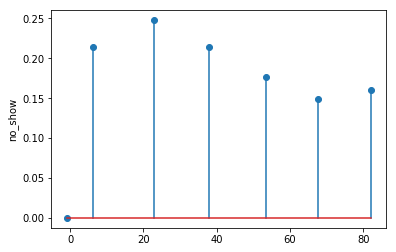

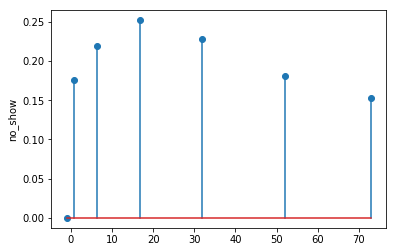

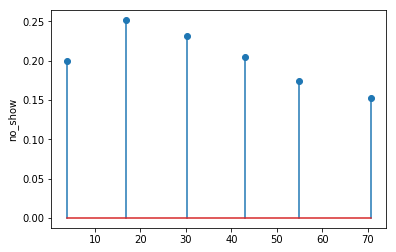

In [371]:

splits, means = analyze_splits(data,'Age',bins = 6, method='linear')
splits, means = analyze_splits(data,'Age',bins = 6, method= 'log', base = 2)
splits, means = analyze_splits(data,'Age',bins = 6, method='quantile')

#Age data is obviously significant. Young adults miss more appointments.

#We'd like to later split more often where there's more variance (ages 0-20 for example)


In [368]:
splits = get_splits(data,'Age',6,'log', base = 2)
data['age_code'] = np.digitize(data['Age'],splits)
#data = data.drop(columns=['Age'])
data[:5]

C:\Users\Ido\Anaconda3\envs\tf15\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,PatientId,AppointmentID,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,...,no_show,is_male,age_code,app_day_code,sch_day_code,app_week_code,sch_week_code,app_year_code,sch_year_code,time_diff
0,2.987250e+13,5642903,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,...,0,0,6,4,4,17,17,2016,2016,0
1,5.589978e+14,5642503,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,...,0,1,5,4,4,17,17,2016,2016,0
2,4.262962e+12,5642549,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,...,0,0,6,4,4,17,17,2016,2016,0
3,8.679512e+11,5642828,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,...,0,0,1,4,4,17,17,2016,2016,0
4,8.841186e+12,5642494,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,...,0,0,5,4,4,17,17,2016,2016,0


## Date

In [141]:
#The two time features are AppointmentDay and ScheduledDay.
#1. Effects of the day of the week (Sunday - Saturday) will be coded 0-6
#2. Effects of the week of the year will be coded 1-54
#Interaction between week and year is sufficient for identifying holidays in the english (Gregorian) calander 
#3. Time difference between scheduling and the appointment is in days (same day appointments are always -1)
import math
import dateutil.parser
seconds_in_day = 24*60*60
time_actions =[{'name': 'app_day_code', 'my_lambda' : lambda x:(dateutil.parser.parse(x['AppointmentDay']).weekday())},
              {'name': 'sch_day_code', 'my_lambda' : lambda x:(dateutil.parser.parse(x['ScheduledDay']).weekday())},
              {'name': 'app_week_code', 'my_lambda' : lambda x:(dateutil.parser.parse(x['AppointmentDay']).isocalendar()[1])},
              {'name': 'sch_week_code', 'my_lambda' : lambda x:(dateutil.parser.parse(x['ScheduledDay']).isocalendar()[1])},
              {'name': 'app_year_code', 'my_lambda' : lambda x:(dateutil.parser.parse(x['AppointmentDay']).year)},
              {'name': 'sch_year_code', 'my_lambda' : lambda x:(dateutil.parser.parse(x['ScheduledDay']).year)},
              {'name': 'time_diff', 'my_lambda' : lambda x:(math.floor((dateutil.parser.parse(x['AppointmentDay'])\
                                        - dateutil.parser.parse(x['ScheduledDay'])).total_seconds()/seconds_in_day+1))}]
data = data[data['time_diff']>-1]
for action in time_actions:
    data[action['name']] = data.apply(action['my_lambda'],axis=1)


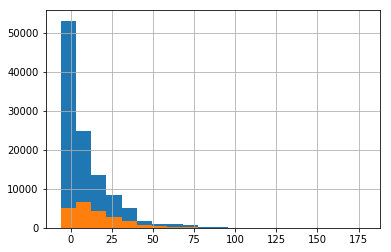

In [142]:
#print(pd.Series(data['time_diff']))

ax = pd.Series(data['time_diff']).hist(bins=20)
ax = pd.Series(data['time_diff'][data['no_show']==1]).hist(bins=20)
plt.show()
#Most patients set their appointment on the day or week of the appointment
#They also miss the appointment less often


In [155]:
#Some outliers here as well, although they may be very significant.
#Let's check this!

for threshold in np.arange(75,200,1):
    print(str(threshold)+':',data[data['time_diff']>threshold].size)

75: 13728
76: 12298
77: 11132
78: 10406
79: 9900
80: 9504
81: 9284
82: 9262
83: 9086
84: 7920
85: 7106
86: 6974
87: 6622
88: 6270
89: 5896
90: 4686
91: 3498
92: 3432
93: 3388
94: 3344
95: 3256
96: 3168
97: 3124
98: 3014
99: 3014
100: 3014
101: 2992
102: 2904
103: 2794
104: 2618
105: 2530
106: 2530
107: 2486
108: 2376
109: 2266
110: 2222
111: 2112
112: 2024
113: 2024
114: 2024
115: 1980
116: 1980
117: 1958
118: 1958
119: 1870
120: 1870
121: 1870
122: 1804
123: 1782
124: 1782
125: 1760
126: 1738
127: 1716
128: 1716
129: 1716
130: 1716
131: 1716
132: 1694
133: 1452
134: 1452
135: 1452
136: 1452
137: 1452
138: 1452
139: 1430
140: 1430
141: 1430
142: 1254
143: 1254
144: 1254
145: 1254
146: 1232
147: 1232
148: 1232
149: 1232
150: 1232
151: 1210
152: 1210
153: 1210
154: 1210
155: 990
156: 990
157: 990
158: 990
159: 990
160: 990
161: 990
162: 748
163: 748
164: 748
165: 748
166: 748
167: 748
168: 748
169: 572
170: 572
171: 572
172: 572
173: 572
174: 572
175: 572
176: 220
177: 220
178: 220
179: 

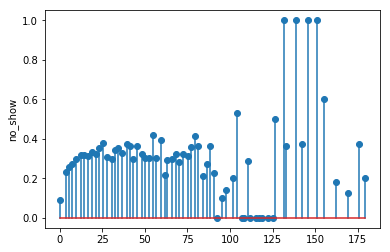

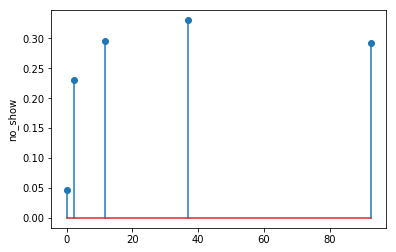

      time_diff   no_show
code                     
1      0.000000  0.046436
2      2.406421  0.229797
3     11.797194  0.295939
4     36.834780  0.330191
5     92.577657  0.291553 [ 0.      0.2864  4.5824 23.1984 73.3184]


In [361]:
mean = analyze_splits(data,column = 'time_diff',bins = 80,method = 'linear')
#The problem is that the outliers are clamped together. let's represent the data in a way that
#segments the larger time differences. using a log scale.
#There could be significance 
splits,mean = analyze_splits(data,column = 'time_diff',bins = 5,method = 'log',base=4)
print(mean, splits)
#I can analyze this data and sagment it where it seems most significant,
#It appears that there are 3 types of appointments:
    #1. same day appointments - very likely to show up
    #2. 30-40 days - unlikely to show up
    #3. 40+ days - more likely to show up (important / premium appointments)

#I should find a quantization algorithm to quantize my data into N levels minimizing the error

In [174]:
#Why do we have clamps of appointments made every Monday? These may have some significance.

data[(data['time_diff']>150).multiply(data['time_diff']<152)]

#They look like noise, maybe added separately, groups of appointments made on the same day

,PatientId,AppointmentID,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,...,no_show,is_male,age_code,app_day_code,sch_day_code,app_week_code,sch_week_code,app_year_code,sch_year_code,time_diff
46292,9.163747e+13,5122866,2015-12-03T08:17:28Z,2016-05-02T00:00:00Z,34,VILA RUBIM,0,1,0,0,...,1,1,5,0,3,18,49,2016,2015,151


In [369]:

splits = get_splits(data,'time_diff',bins = 5,method = 'log', base = 4 )
data['time_diff_code'] = np.digitize(data['time_diff'],splits)

C:\Users\Ido\Anaconda3\envs\tf15\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [189]:
data['Neighbourhood'].unique().size
np.power(np.linspace(0,1,19)[:-1],0.2)

array([0.        , 0.56097757, 0.64439401, 0.69882712, 0.74021434,
       0.7739974 , 0.80274156, 0.82787565, 0.850283  , 0.87055056,
       0.88908954, 0.90619995, 0.92210791, 0.9369883 , 0.95097939,
       0.9641925 , 0.97671868, 0.98863341])

In [370]:
data

,PatientId,AppointmentID,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,...,is_male,age_code,app_day_code,sch_day_code,app_week_code,sch_week_code,app_year_code,sch_year_code,time_diff,time_diff_code
0,2.987250e+13,5642903,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,...,0,6,4,4,17,17,2016,2016,0,1
1,5.589978e+14,5642503,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,...,1,5,4,4,17,17,2016,2016,0,1
2,4.262962e+12,5642549,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,...,0,6,4,4,17,17,2016,2016,0,1
3,8.679512e+11,5642828,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,...,0,1,4,4,17,17,2016,2016,0,1
4,8.841186e+12,5642494,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,...,0,5,4,4,17,17,2016,2016,0,1
5,9.598513e+13,5626772,2016-04-27T08:36:51Z,2016-04-29T00:00:00Z,76,REPÚBLICA,0,1,0,0,...,0,6,4,2,17,17,2016,2016,2,2
6,7.336882e+14,5630279,2016-04-27T15:05:12Z,2016-04-29T00:00:00Z,23,GOIABEIRAS,0,0,0,0,...,0,2,4,2,17,17,2016,2016,2,2
7,3.449833e+12,5630575,2016-04-27T15:39:58Z,2016-04-29T00:00:00Z,39,GOIABEIRAS,0,0,0,0,...,0,4,4,2,17,17,2016,2016,2,2
8,5.639473e+13,5638447,2016-04-29T08:02:16Z,2016-04-29T00:00:00Z,21,ANDORINHAS,0,0,0,0,...,0,2,4,4,17,17,2016,2016,0,1
9,7.812456e+13,5629123,2016-04-27T12:48:25Z,2016-04-29T00:00:00Z,19,CONQUISTA,0,0,0,0,...,0,2,4,2,17,17,2016,2016,2,2
